<a href="https://colab.research.google.com/github/DrewHopkins/Nozzle-Design/blob/main/Nozzle_Design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Functions and Definitions

In [ ]:
!pip install anvil-uplink
import numpy as np
import math
from sympy import *
from shapely.geometry import LineString
from shapely.geometry import MultiPoint
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches


     |████████████████████████████████| 64 kB 1.2 MB/s 
     |████████████████████████████████| 51 kB 81 kB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45229 sha256=d08aa28b473c229787bce9d5200d360e7659826c4ec9ce2f1b5879fe126d5d19
  Stored in directory: /root/.cache/pip/wheels/29/ea/7d/3410aa0aa0e4402ead9a7a97ab2214804887e0f5c2b76f0c96
Successfully built ws4py


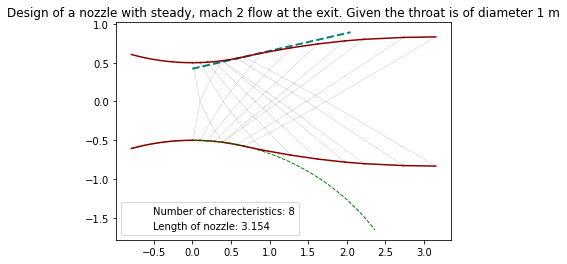

In [ ]:
def prandtl_meyer(M,gam):
  x = np.sqrt((gam+1)/(gam-1))*np.arctan(np.sqrt((gam-1)/(gam+1)*(M**2-1)))-np.arctan(np.sqrt(M**2-1))
  return math.degrees(x)

# solves the prendtl meyer function for the mach number
def mach_prandtl_meyer(v,gam):
  M = np.linspace(1,10,50000)
  x = np.sqrt((gam+1)/(gam-1))*np.arctan(np.sqrt((gam-1)/(gam+1)*(M**2-1)))-np.arctan(np.sqrt(M**2-1))
  y = math.radians(v) - M + M
  line1 = LineString(np.column_stack((M,x)))
  line2 = LineString(np.column_stack((M,y)))
  M_soln = line1.intersection(line2)
  return M_soln.x

def angle(v, gam):  
  return math.degrees(np.arcsin(1 / mach_prandtl_meyer(v,gam)))

def Cplus_slope(theta,μ):
  return np.tan(((theta + μ)*np.pi/180))

def Cminus_slope(theta,μ):
  return np.tan(((theta - μ)*np.pi/180))

def intersection_fun(y1,y2,xx):
    line1 = LineString(np.column_stack((xx,y1)))
    line2 = LineString(np.column_stack((xx,y2)))
    coord = line1.intersection(line2)
    if type(coord) is MultiPoint:
     coord = coord[0]
    return coord.x, coord.y

def area_Ratio(Mexit,gam):
  ratio = np.sqrt(1/(Mexit**2)*(2/(gam+1)*(1+((gam-1)/2)*Mexit**2))**((gam+1)/(gam-1)))
  return ratio

# <center> Problem 11.1 in Anderson

<center>Using the method of characteristics, compute and graph the contour of a two-dimensional minimum-length nozzle for the expansion of air to a design exit Mach number of 2.

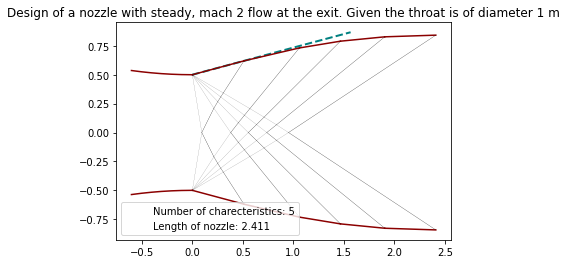

In [ ]:
import anvil.server
import anvil.mpl_util
anvil.server.connect("G6OQIYUCZRCJBGYVW5ZWBB37-U3RR3NI4IFCIJM57")
@anvil.server.callable
def minimalLength(throat_area, Mexit, gam, ncl):
  plt.clf()
  throat_area = int(throat_area) 
  Mexit = int(Mexit) 
  gam = float(gam)
  ncl = int(ncl)
  theta_one = .1 
  prandtl_meyer_max = prandtl_meyer(Mexit,gam)
  theta_max = prandtl_meyer_max / 2 # theta_max for the nozzle profile in degrees
  area_ratio = area_Ratio(Mexit,gam)
  area_exit = area_ratio*throat_area # quasi-one dimensional relation 
            # (used to get out technique within a percentage point of accuarcy)
                                  
  ## we are interested in each charecteristic line intersections
  #  we will call these interections (i,j)
  #  where i corresponds the C+ charecteristic
  #    and j corresponds the C- charecteristic
  # choose thetas to the C- charecteristic lines coming from the throat
  data = [['Point','θ','ν','μ','C+ slope','C- slope','x','y'],[1,theta_one]]
  interval = (theta_max-theta_one)/(ncl-1)
  for i in range(1,ncl):
    theta = data[i][1]+interval
    data.append([i+1,theta])
  # calculate the K+ and K- rienmann constants on these charecteristics 
  # C-
  Kminus = []
  for i in range(1,ncl+1):
    Kminus.append(2*data[i][1])
  # C+
  Kplus = [0]
  for i in range(1,ncl):
    Kplus.append(-Kminus[i])  
  charecteristics = [['K+','K-'],Kplus,Kminus]

  ###### calculate data at each point so we may find slopes ######
  # ν and μ for points in first simple region
  for i in range(ncl):
    ν = 1/2*(charecteristics[2][i] - charecteristics[1][0])
    data[i+1].append(ν)
    μ = angle(ν, gam)
    data[i+1].append(μ)
  data.append([ncl+1,data[ncl][1],ν,μ]) ## point at wall

  # θ, ν, and μ for points in non-simple region and on wall
  point = ncl + 2
  for i in range(1,ncl):
    j=i
    while ncl > j >= i:
      θ = 1/2*(charecteristics[2][j] + charecteristics[1][i])
      ν = 1/2*(charecteristics[2][j] - charecteristics[1][i])
      μ = angle(ν, gam)
      data.append([point,θ,ν,μ])
      point = point + 1
      j = j + 1
    data.append([point,θ,ν,μ]) ## point at wall
    point = point + 1

  # slopes
  for i in range(1,len(data)):
    slope1 = Cplus_slope(data[i][1],data[i][3])
    data[i].append(slope1)
    slope2 = Cminus_slope(data[i][1],data[i][3])
    data[i].append(slope2)

  # coordiantes of throat ceiling
  y0 = throat_area/2
  x0 = 0

  # assumed simple region functions
  simple_region = []
  xx = np.linspace(0,30,300)
  for i in range(ncl):
    simple_region.append(data[i+1][5]*xx + y0)

  # point one
  point = 1
  y = 0 - xx + xx
  x , y = intersection_fun(simple_region[0],y,xx)
  data[point].append(x)
  data[point].append(y)

  # using assumed simple region functions
  for i in range(1,ncl):
      point = point + 1
      y = data[point][4]*(xx-data[point - 1][6])+data[point - 1][7]
      x,y = intersection_fun(simple_region[i],y,xx)
      data[point].append(x)
      data[point].append(y)
  point = point + 1
  y = np.tan(1/2*math.radians(theta_max+data[point][1]))*(xx) + y0
  yy = data[point][4]*(xx-data[point-1][6]) + data[point-1][7]
  x,y = intersection_fun(yy,y,xx)
  data[point].append(x)
  data[point].append(y)

  # non simple region
  for q in range (1,ncl): # find points on axisymmetric line
    point = point + 1
    avg = 1/2*(data[point-ncl-1+q][5]+data[point][5])
    y = avg*(xx-data[point-ncl-1+q][6]) + data[point-ncl-1+q][7]
    yy = 0 - xx + xx
    x,y = intersection_fun(yy,y,xx)
    data[point].append(x)
    data[point].append(y) 
    for i in range(1,ncl-q):
      point = point + 1
      Cplus_avg = 1/2*(data[point][4]+data[point-1][4])
      Cminus_avg = 1/2*(data[point][5]+data[point-ncl-1+q][5])
      y = Cplus_avg*(xx-data[point-1][6])+data[point-1][7]
      yy = Cminus_avg*(xx-data[point-ncl-1+q][6])+data[point-ncl-1+q][7]
      x,y = intersection_fun(yy,y,xx)
      data[point].append(x)
      data[point].append(y)
    point = point + 1
    avgslope = (np.tan(1/2*(data[point-ncl-1+q][1]+data[point][1])*np.pi/180))
    y = avgslope*(xx-data[point-ncl-1+q][6]) + data[point-ncl-1+q][7]
    yy = data[point][4]*(xx-data[point-1][6]) + data[point-1][7]
    x,y = intersection_fun(yy,y,xx)
    data[point].append(x)
    data[point].append(y)
  for row in data:
      print("{: >20} {: >20} {: >20} {: >20} {: >20} {: >20} {: >20} {: >20}".format(*row))

  # show theta max
  xx = np.linspace(0,data[-1][6]*.65,300)
  y = np.tan(theta_max*np.pi/180)*xx+y0
  plt.plot(xx,y,color ='teal' , linewidth=2, linestyle = 'dashed',Label = 'Maximum Theta of wall')

  # converging profile
  xx = np.linspace(-data[-1][6]*.25,0,300)
  conv = .1*xx**2 + y0
  plt.plot(xx,conv,color = 'darkred')
  plt.plot(xx,-conv,color = 'darkred')

  # diverging profile
  plt.plot([0,data[ncl+1][6]],[y0,data[ncl+1][7]], color = 'darkred')
  plt.plot([0,data[ncl+1][6]],[-y0,-data[ncl+1][7]], color = 'darkred')
  point = ncl+1
  for q in range (ncl-1):
    plt.plot([data[point][6],data[point+ncl-q][6]],[data[point][7],data[point+ncl-q][7]], color = 'darkred')
    plt.plot([data[point][6],data[point+ncl-q][6]],[-data[point][7],-data[point+ncl-q][7]], color = 'darkred')
    point = point+ncl-q

  ######### charecteristics
  point = 0

  # C- lines
  Cminus_points = []
  for i in range(ncl):
    Cminus_points.append([0])
  for i in range(ncl):
    Cminus_points[i].append(i+1)
  for q in range(ncl-1): 
    for i in range(q+1,ncl):
      Cminus_points[i].append(ncl-q+Cminus_points[i][-1])
  for m in range(ncl):
    plt.plot([0,data[m+1][6]],[y0,data[m+1][7]], color ='black' , linewidth=.1)
    plt.plot([0,data[m+1][6]],[-y0,-data[m+1][7]] , color = 'black', linewidth=.1)
  for m in range(1,ncl):
    for n in range(2,len(Cminus_points[m])):
      point1 = Cminus_points[m][n-1]
      point2 = Cminus_points[m][n]
      plt.plot([data[point1][6],data[point2][6]],[data[point1][7],data[point2][7]],color ='black' , linewidth=.1)
      plt.plot([data[point1][6],data[point2][6]],[-data[point1][7],-data[point2][7]],color ='black' , linewidth=.1)

  # C+ lines
  Cplus_points = []
  for i in range(ncl):
    Cplus_points.append([])
  point = 0
  for m in range(ncl):
    for n in range(1,ncl+2-m):
      point = point + 1
      Cplus_points[m].append(point)
  for m in range(ncl):
    for n in range(1,len(Cplus_points[m])):
      point1 = Cplus_points[m][n-1]
      point2 = Cplus_points[m][n]
      plt.plot([data[point1][6],data[point2][6]],[data[point1][7],data[point2][7]],color ='black' , linewidth=.25)
      plt.plot([data[point1][6],data[point2][6]],[-data[point1][7],-data[point2][7]],color ='black' , linewidth=.25)

  plt.title('Mach {} flow at the exit. Given the throat is of diameter {} m'.format(Mexit,throat_area))
  handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", lw=0, alpha=0)] * 2
  labels = []
  labels.append('Number of charecteristics: {}'.format(ncl))
  labels.append("Length of nozzle: {}".format(round(data[-1][6],3)))
  plt.legend(handles,labels)
  x=round(data[-1][7]*2,3)
  xx=round(area_exit,3)
  print('The height of the nozzle at the exit is {}m'.format(x))
  print('Which compares to the quasi one dimensional height of {}m'.format(xx))
  print('A {} % match'.format(round(abs(x)/xx*100,3)))
  image = anvil.mpl_util.plot_image()
  return image

# <center>Problem 11.2 in Anderson

<center>Repeat problem 11.1, except consider a nozzle with a finite expansion section which is a circular arc with radius equal to three throat heights. Compare this nozzle contour and total length with the minimum-length nozzle of problem 11.1.

In [ ]:
def y_roc_fun(x, throat_area):
  return (-np.sqrt((3*throat_area)**2-x**2)+ 7*throat_area/2)

In [ ]:
import anvil.server
import anvil.mpl_util
anvil.server.connect("G6OQIYUCZRCJBGYVW5ZWBB37-U3RR3NI4IFCIJM57")
@anvil.server.callable
def smoothNozzle(throat_area, Mexit, gam , ncl):
  plt.clf()
  Mexit = int(Mexit) 
  gam = float(gam)
  ncl = int(ncl)
  theta_one = .1 
  # write an equation for the expansion region profile
  roc = 3*throat_area
  xx = np.linspace(0,0.3*throat_area,300)
  y_roc = y_roc_fun(xx, throat_area)
  # note that the max angle in this senario must be less than the max angle given
  # by the equation
  prandtl_meyer_max = prandtl_meyer(Mexit,gam)
  theta_max_limit = prandtl_meyer_max / 2 
  theta_max = .98*theta_max_limit # let max angle be 98% of the min length max angle
  area_ratio = area_Ratio(Mexit,gam)
  area_exit = area_ratio*throat_area

  # choose thetas to the C- charecteristic lines coming from the throat
  data = []
  data.append(['Point','θ','ν','μ','C+ slope','C- slope','x','y'])
  data.append([1,theta_one])
  interval = (theta_max-theta_one)/(ncl-1)
  for i in range(1,ncl):
    theta = data[i][1]+interval
    data.append([i+1,theta])

  # calculate the K+ and K- rienmann constants on these charecteristics 
  # C-
  Kminus = []
  for i in range(1,ncl+1):
    Kminus.append(2*data[i][1])
  # C+
  Kplus = [0]
  for i in range(1,ncl):
    Kplus.append(-Kminus[i]) 
  charecteristics = [['K+','K-'],Kplus,Kminus]

  ###### calculate data at each point so we may find slopes ######
  # ν and μ for points in first simple region
  for i in range(ncl):
    ν = 1/2*(charecteristics[2][i] - charecteristics[1][0])
    data[i+1].append(ν)
    μ = angle(ν, gam)
    data[i+1].append(μ)
  data.append([ncl+1,data[ncl][1],ν,μ]) ## point on wall

  # θ, ν, and μ for points in non-simple region and on wall
  point = ncl + 2
  for i in range(1,ncl):
    j=i
    while ncl > j >= i:
      θ = 1/2*(charecteristics[2][j] + charecteristics[1][i])
      ν = 1/2*(charecteristics[2][j] - charecteristics[1][i])
      μ = angle(ν, gam)
      data.append([point,θ,ν,μ])
      point = point + 1
      j = j + 1
    data.append([point,θ,ν,μ]) ## point on wall
    point = point + 1
  # slopes
  for i in range(1,len(data)):
    slope1 = Cplus_slope(data[i][1],data[i][3])
    data[i].append(slope1)
    slope2 = Cminus_slope(data[i][1],data[i][3])
    data[i].append(slope2) 

  y0 = throat_area/2
  x0 = 0
  xx = np.linspace(0,3*throat_area-1,300)
  y_roc_prime = xx*((3*throat_area)**2-xx**2)**(-1/2)
  slope = np.tan(theta_max*np.pi/180)+xx-xx
  x_max,y_max = intersection_fun(y_roc_prime,slope,xx)

  # coordinates of starting points of charecteristics in exapsion region
  array = []
  for i in range(ncl):
    array.append([])
    y = np.tan(data[i+1][1]*np.pi/180)+xx-xx
    x,y = intersection_fun(y_roc_prime,y,xx)
    y = y_roc_fun(x, throat_area)
    array[i].append(x)
    array[i].append(y)

  # assumed simple region
  point = 0
  simple_region = []
  for i in range(ncl):
    point = point+1
    xx = np.linspace(0,2,300)
    y = data[point][5]*(xx-array[i][0]) + array[i][1]
    simple_region.append([y])

  # point one
  point = 1
  y = 0 - xx + xx
  x , y = intersection_fun(simple_region[0][0],y,xx)
  data[point].append(x)
  data[point].append(y)

  # using assumed simple region functions
  xx = np.linspace(0,3*throat_area-1,300)
  n=1
  while n < ncl:
      point = point + 1
      y1 = data[point][4]*(xx-data[point - 1][6])+data[point - 1][7]
      x,y = intersection_fun(simple_region[n][0],y1,xx)
      x_,y_ = intersection_fun(y_roc_fun(xx, throat_area),y1,xx)
      if y > y_:
        data[point].append(x_)
        data[point].append(y_)
        for i in range(n+1,ncl):
          point = point+1
          data[point].append(array[i][0])
          data[point].append(array[i][1])
        n=ncl+1
      else:
        data[point].append(x)
        data[point].append(y)
        n=n+1
  point = point + 1
  y1 = data[point][5]*(xx-array[-1][0]) + array[-1][1]
  y2 = ((data[point][4]))*(xx-data[point-1][6]) + data[point-1][7]
  x,y = intersection_fun(y1,y2,xx)
  x_,y_ = intersection_fun(y_roc_fun(xx, throat_area),y2,xx)
  if y > y_:
    data[point].append(x_)
    data[point].append(y_)
  else:
      data[point].append(x)
      data[point].append(y)

  # non simple region
  for q in range (1,ncl): # find points on axisymmetric line
    xx = np.linspace(0,30,300)
    point = point + 1
    avg = 1/2*(data[point-ncl-1+q][5]+data[point][5])
    y = avg*(xx-data[point-ncl-1+q][6]) + data[point-ncl-1+q][7]
    yy = 0 - xx + xx
    x,y = intersection_fun(yy,y,xx)
    data[point].append(x)
    data[point].append(y) 
    for i in range(1,ncl-q):
      point = point + 1
      Cplus_avg = 1/2*(data[point][4]+data[point-1][4])
      Cminus_avg = 1/2*(data[point][5]+data[point-ncl-1+q][5])
      y = Cplus_avg*(xx-data[point-1][6])+data[point-1][7]
      yy = Cminus_avg*(xx-data[point-ncl-1+q][6])+data[point-ncl-1+q][7]
      x,y = intersection_fun(yy,y,xx)
      if x>x_max:
        data[point].append(x)
        data[point].append(y)
      else:
          xx = np.linspace(0,3*throat_area-1,300)
          y1 = Cplus_avg*(xx-data[point-1][6])+data[point-1][7]
          x_,y_ = intersection_fun(y1,y_roc_fun(xx, throat_area),xx)  
          if y<y_:
            data[point].append(x)
            data[point].append(y)    
          else:
            xx = np.linspace(0,3*throat_area-1,300)
            y1 = Cplus_avg*(xx-data[point-1][6])+data[point-1][7]
            x,y = intersection_fun(y1,y_roc_fun(xx, throat_area),xx)
            data[point].append(x)
            data[point].append(y)
    point = point + 1
    avgslope = np.tan(1/2*(data[point-ncl-1+q][1]+data[point][1])*np.pi/180)
    y = avgslope*(xx-data[point-ncl-1+q][6]) + data[point-ncl-1+q][7]
    yy = data[point][4]*(xx-data[point-1][6]) + data[point-1][7]
    x,y = intersection_fun(yy,y,xx)
    data[point].append(x)
    data[point].append(y)

  for row in data:
      print("{: >20} {: >20} {: >20} {: >20} {: >20} {: >20} {: >20} {: >20}".format(*row))
  height=round(data[-1][7]*2,3)
  q_height=round(area_exit,3)

  # show theta max tangent line
  xx = np.linspace(0,data[-1][6]*.65,300)
  slope = np.tan(theta_max*np.pi/180)+xx-xx
  x_max,y = intersection_fun(y_roc_prime,slope,xx)
  y_max = y_roc_fun(x_max, throat_area)
  y = slope*(xx-x_max)+y_max
  plt.plot(xx,y,color ='teal' , linewidth=2, linestyle = 'dashed',Label = 'Maximum Theta of wall')

  # expansion region profile
  for i in range(ncl-1): 
    plt.plot([array[i][0],array[i+1][0]],[array[i][1],array[i+1][1]],color='darkred')
    plt.plot([array[i][0],array[i+1][0]],[-array[i][1],-array[i+1][1]],color='darkred')

  # converging profile
  xx = np.linspace(-data[-1][6]*.25,data[-1][6]*.75,300)
  plt.plot(xx,-y_roc_fun(xx, throat_area),color='g',linewidth=1,linestyle='dashed')
  xx = np.linspace(-data[-1][6]*.25,0,300)
  plt.plot(xx,y_roc_fun(xx, throat_area),color = 'darkred')
  plt.plot(xx,-y_roc_fun(xx, throat_area),color = 'darkred')

  # diverging profile
  plt.plot([array[-1][0],data[ncl+1][6]],[array[-1][1],data[ncl+1][7]], color = 'darkred')
  plt.plot([array[-1][0],data[ncl+1][6]],[-array[-1][1],-data[ncl+1][7]], color = 'darkred')
  point = ncl+1
  for q in range (ncl-1):
    plt.plot([data[point][6],data[point+ncl-q][6]],[data[point][7],data[point+ncl-q][7]], color = 'darkred')
    plt.plot([data[point][6],data[point+ncl-q][6]],[-data[point][7],-data[point+ncl-q][7]], color = 'darkred')
    point = point+ncl-q

  ######### charecteristics
  point = 0
  # C- lines
  Cminus_points = []
  for i in range(ncl):
    Cminus_points.append([0])
  for i in range(ncl):
    Cminus_points[i].append(i+1)
  for q in range(ncl-1): 
    for i in range(q+1,ncl):
      Cminus_points[i].append(ncl-q+Cminus_points[i][-1])
  for m in range(ncl):
    plt.plot([array[m][0],data[m+1][6]],[array[m][1],data[m+1][7]], color ='black' , linewidth=.1)
    plt.plot([array[m][0],data[m+1][6]],[-array[m][1],-data[m+1][7]] , color = 'black', linewidth=.1)
  for m in range(1,ncl):
    for n in range(2,len(Cminus_points[m])):
      point1 = Cminus_points[m][n-1]
      point2 = Cminus_points[m][n]
      plt.plot([data[point1][6],data[point2][6]],[data[point1][7],data[point2][7]],color ='black' , linewidth=.1)
      plt.plot([data[point1][6],data[point2][6]],[-data[point1][7],-data[point2][7]],color ='black' , linewidth=.1)

  # C+ lines
  Cplus_points = []
  for i in range(ncl):
    Cplus_points.append([])
  point = 0
  for m in range(ncl):
    for n in range(1,ncl+2-m):
      point = point + 1
      Cplus_points[m].append(point)
  for m in range(ncl):
    for n in range(1,len(Cplus_points[m])):
      point1 = Cplus_points[m][n-1]
      point2 = Cplus_points[m][n]
      plt.plot([data[point1][6],data[point2][6]],[data[point1][7],data[point2][7]],color ='black' , linewidth=.1)
      plt.plot([data[point1][6],data[point2][6]],[-data[point1][7],-data[point2][7]],color ='black' , linewidth=.1)
  plt.title('Mach {} flow at the exit. Given the throat is of diameter {} m'.format(Mexit,throat_area))
  handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", lw=0, alpha=0)] * 2
  labels = []
  labels.append('Number of charecteristics: {}'.format(ncl))
  labels.append("Length of nozzle: {}".format(round(data[-1][6],3)))
  plt.legend(handles,labels)
  print('The height of the nozzle at the exit is {}m'.format(height))
  print('Which compares to the quasi one dimensional height of {}m'.format(q_height))
  print('A {} % match'.format(round(abs(height)/q_height*100,3)))
  image = anvil.mpl_util.plot_image()
  return image


# <center>Problem 11.3 in Anderson

<center>Consider the external supersonic flow over the pointed body sketched in Fig. 11.22. Outline in detail how you would set up a method-of-characteristics solution for this flow.

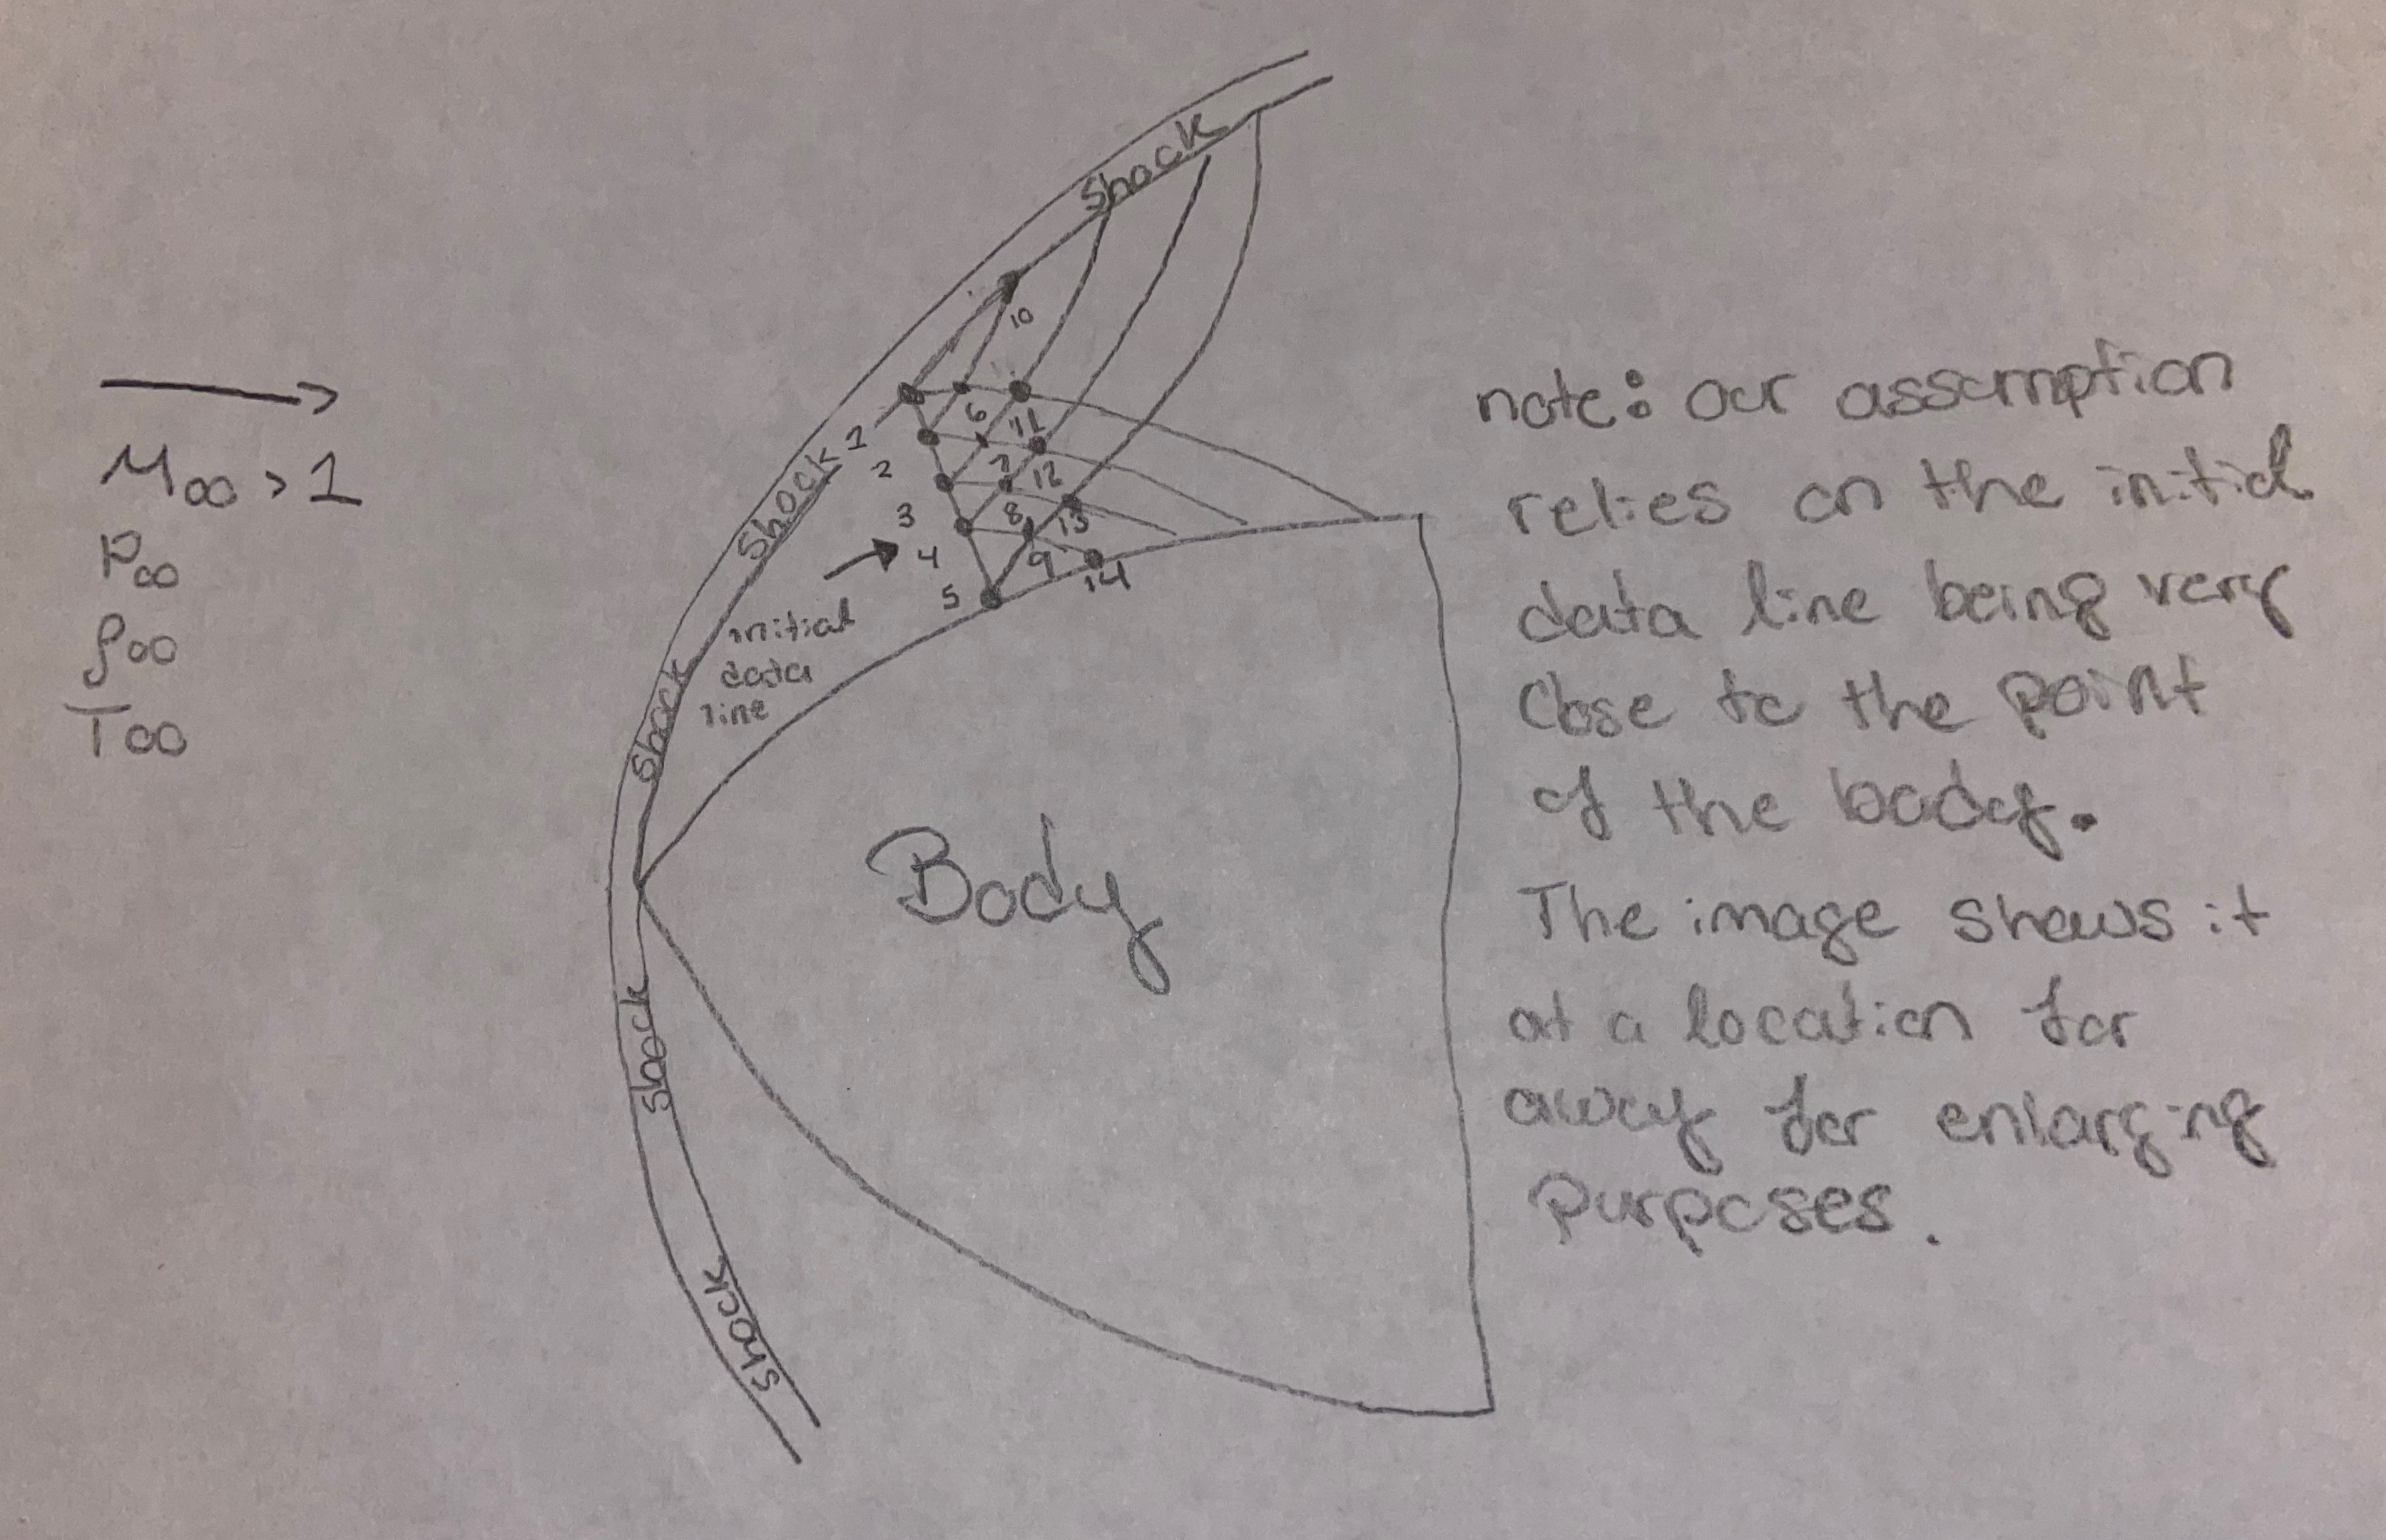

$$Givens:M_{\infty} \text{, } p_{\infty} \text{, } \rho_{\infty} \text{, } T_{\infty} \text{, } \theta_{\text{at each point on body}}$$

In order to obtain a solution to the flow field between the bow shock and the pointed body, we will need to make one key assumption where the surface of the pointed body is straight when we look extremely close to the point of the pointed body. This allows us to take the region of the assumed straight edge to have a corresponding oblique shock. Noting we are given $\theta$ and $M_{\infty}$, we can use the $\theta$-$\beta$-$M_{\infty}$ relation given below to determine $\beta$ of the assumed oblique shock iteratively. 

$$tan(\theta) = 2cot(\beta)*[\frac{M_{\infty}^2*sin^2(\beta)-1}{M_{\infty}^2(\gamma+cos(2\beta))+2}]$$

After obtaining the $\beta$ of the shock angle, we can apply the normal component of the flow relative to the shock to the normal shock relations and then combine it back with the tangential component to find the properties behind the assumed region. This point behind the shock is point number 1. Next, draw a steep negative slope line downwards to the pointed body’s surface. We will call this intersection between the line just drawn and the body point number 5. Based on our assumption of the wall of the pointed object being straight, we can calculate the properties at every point on this line by using wedge-flow properties. Let’s only consider 3 points (Points 2, 3, and 4) for our purposes of the method of characteristics. We call this line the initial data line.   
Now, at point 1 we can draw a $C_-$ characteristic using the (A) formula given from Andreson’s 11.14.
\begin{align}\\
    \text{A:}&\ \ (\frac{dy}{dx})_{char} = tan(\theta - \nu)\\
    \text{B:}&\ \ (\frac{dy}{dx})_{char} = tan(\theta + \nu) $$
\end{align}
Next, at point 2 we will draw a $C_+$ characteristic using the (B) formula as above until it intersects the previously drawn $C_-$ characteristic. Note: The slope drawn from the equations above is only valid at the point of interest we will later define a more accurate location of intersection. Call this intersection point number 6. We can obtain flow properties from this intersection using Anderson’s formulas 11.24 and 11.25.
\begin{align}\
    \text{11.24:}&\ \ \theta_3 = \frac{1}{2}[(K_-)_1+(K_+)_2]\\
    \text{11.25:}&\ \ \nu = \frac{1}{2}[(K_-)_1-(K_+)_2]
\end{align}
 To find a better approximation for the location of point 6 we will use avg slopes to define the $C_+$ and $C_-$ characteristics’ slopes. The following equation is used to find the average slope of the $C_-$ characteristic, but the same can be applied to the $C_+$ by replacing the index of point 1 to the index of point 2 and the subtraction sign with an addition sign.
$$avg = \frac{1}{2}[(\theta_1 +\theta_3)-(\mu_1+\mu_3)]$$
Repeat these steps for points 2-3 to create point 7, 3-4 creating point 8, and finally, 4-5 creating point 9.
Next, draw a $C_+$ characteristic from point 6 using corresponding values for 11.14 (B) until the shock surface is reached. Call it point number 10. At point 10, all we are given initially is the Riemann Invariant and $M_{\infty}$ which comes from point 6 and initial flow conditions. To find the properties at 10, we will iteratively find $\beta_{10}$ that contains a $\theta_{10}$ and $\nu_{10}$ that satisfy the Riemann Invariant constraint. And then use the oblique shock method stated before to find the flow properties at point 10. Again note that the average slope equation must be used to find the locations of each point described as an intersection. 
For points 11, 12, and 13, we use the same method that created point 6, 7, 8, and 9 to calculate each point flow properties.
At point 9, we will now draw a $C_-$ characteristic to the body’s surface. Call this intersection point 14. Since we are given the Riemann Invariant of the $C_-$ characteristic and the $\theta_{14}$, which is the flow direction which is tangent to the wall of the body, for the $C_+$ characteristic coming out of point 14, then we are able to solve for $\nu_{14}$. 
Notice, if we look at points 10 through 14, you may see that the same process from points 1 through 5 can be carried out to create many more points in the flow field. Repeat this process until the end of the point body is reached. Also, realize if you want more accuracy and more flow field points, then you would need to increase the number of characteristics by increasing the number of points used on the initial data line.





#Anvil

               Point                    θ                    ν                    μ             C+ slope             C- slope                    x                    y
                   1                  0.1                  0.1    79.46323986865661    5.428951801884791     -5.3245570786798  0.09914136258287265                  0.0
                   2   1.9322975426534377   1.9322975426534377    62.30145047344965   2.0717126143100284  -1.7581137537151403  0.23106566102199178   0.2733092332103239
                   3   3.7645950853068753   3.7645950853068753   55.851092611512556   1.7055284795864494  -1.2839322250454523   0.2944180768608642  0.38135858267412454
                   4    5.596892627960313    5.596892627960313   51.438317063053304     1.54193860336808  -1.0298111927838283   0.3453783119732132   0.4599361364305691
                   5     7.42919017061375     7.42919017061375   48.014247886115974   1.4519363127204408  -0.8566513852893249  0.38942078449108036   0.523883001

KeyboardInterrupt: ignored

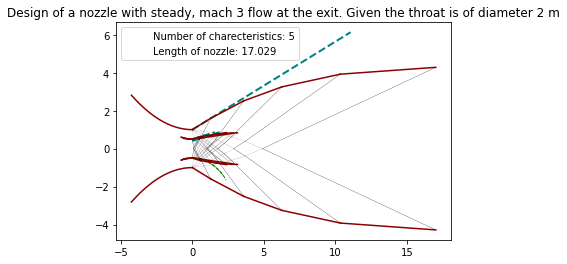

In [ ]:
anvil.server.wait_forever()